In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load cleaned returns and optimized weights
# Load cleaned returns and optimized weights
returns = pd.read_csv("../data/returns_clean.csv", index_col=0)
returns.index = pd.to_datetime(returns.index)  # <-- ✅ Fix index parsing
weights_df = pd.read_csv("../data/optimized_weights.csv", index_col=0)
weights = weights_df['Weight'].values
assets = weights_df.index.tolist()

# Align returns with available assets
returns = returns[assets]

# Calculate portfolio returns
portfolio_returns = returns.dot(weights)


In [13]:
# Scenario A: Single-day crash (simulate 10% drop on a known crash day)
crash_day = pd.Timestamp('2020-03-16')
returns_crash = returns.copy()
if crash_day in returns_crash.index:
    returns_crash.loc[crash_day, :] -= 0.10

# Scenario B: Multi-day crash (simulate 5% daily loss for COVID crash period)
start_crash = pd.Timestamp('2020-03-09')
end_crash = pd.Timestamp('2020-03-20')
returns_crash.loc[start_crash:end_crash, :] -= 0.05

# Scenario C: Volatility spike (simulate 2x volatility)
vol_spike_returns = portfolio_returns * 2

In [14]:
# Define risk metrics
def calculate_var_cvar(returns_series, confidence_level=0.95):
    var = np.percentile(returns_series, (1 - confidence_level) * 100)
    cvar = returns_series[returns_series <= var].mean()
    return var, cvar

def sharpe_ratio(returns_series):
    return returns_series.mean() / returns_series.std() * np.sqrt(252)

def directional_accuracy(actual):
    shifted = actual.shift(1).dropna()
    return (np.sign(actual[1:]) == np.sign(shifted)).mean()

def max_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    return drawdown.min()



In [15]:
# Calculate original and stress returns
portfolio_returns_crash = returns_crash.dot(weights)
cumulative_original = (1 + portfolio_returns).cumprod()
cumulative_crash = (1 + portfolio_returns_crash).cumprod()
cumulative_vol_spike = (1 + vol_spike_returns).cumprod()


In [16]:
# Compute metrics
original_var, original_cvar = calculate_var_cvar(portfolio_returns)
stress_var, stress_cvar = calculate_var_cvar(portfolio_returns_crash)
vol_var, vol_cvar = calculate_var_cvar(vol_spike_returns)

sharpe_orig = sharpe_ratio(portfolio_returns)
sharpe_stress = sharpe_ratio(portfolio_returns_crash)
sharpe_vol = sharpe_ratio(vol_spike_returns)

dd_orig = max_drawdown(cumulative_original)
dd_stress = max_drawdown(cumulative_crash)
dd_vol = max_drawdown(cumulative_vol_spike)

acc_orig = directional_accuracy(portfolio_returns)
acc_stress = directional_accuracy(portfolio_returns_crash)
acc_vol = directional_accuracy(vol_spike_returns)

In [17]:
# Combine into summary table
summary_df = pd.DataFrame({
    "Metric": ["VaR 95%", "CVaR 95%", "Sharpe Ratio", "Max Drawdown", "Directional Accuracy"],
    "Original": [original_var, original_cvar, sharpe_orig, dd_orig, acc_orig],
    "Stress": [stress_var, stress_cvar, sharpe_stress, dd_stress, acc_stress],
    "Vol Spike": [vol_var, vol_cvar, sharpe_vol, dd_vol, acc_vol]
})
summary_df.to_csv("../data/stress_test_metrics.csv", index=False)
print("✅ Saved stress test metrics to ../data/stress_test_metrics.csv")

✅ Saved stress test metrics to ../data/stress_test_metrics.csv


In [18]:
# Save daily return series
pd.DataFrame({
    "Original": portfolio_returns,
    "Stress": portfolio_returns_crash,
    "Vol Spike": vol_spike_returns
}).to_csv("../data/stress_return_series.csv")
print("✅ Saved stress return series to ../data/stress_return_series.csv")

✅ Saved stress return series to ../data/stress_return_series.csv


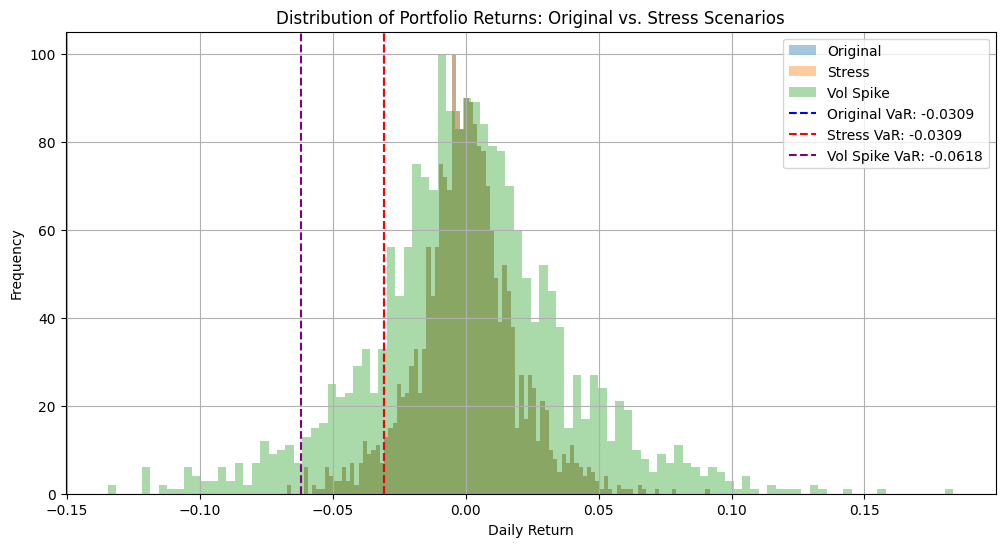

In [19]:
# Plot: Histogram of returns
plt.figure(figsize=(12,6))
plt.hist(portfolio_returns, bins=100, alpha=0.4, label='Original')
plt.hist(portfolio_returns_crash, bins=100, alpha=0.4, label='Stress')
plt.hist(vol_spike_returns, bins=100, alpha=0.4, label='Vol Spike')
plt.axvline(original_var, color='blue', linestyle='--', label=f'Original VaR: {original_var:.4f}')
plt.axvline(stress_var, color='red', linestyle='--', label=f'Stress VaR: {stress_var:.4f}')
plt.axvline(vol_var, color='purple', linestyle='--', label=f'Vol Spike VaR: {vol_var:.4f}')
plt.title("Distribution of Portfolio Returns: Original vs. Stress Scenarios")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

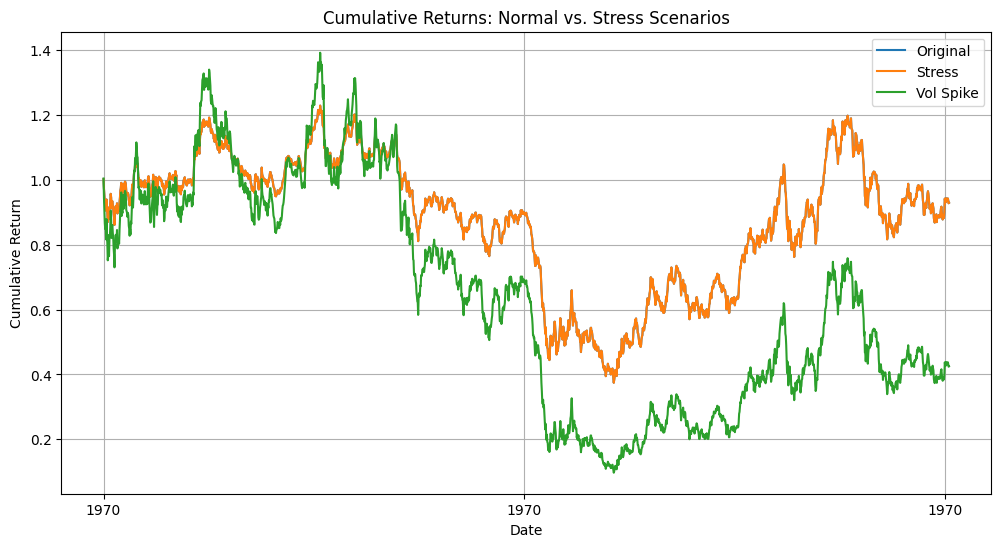

In [20]:
# Plot: Cumulative returns comparison
plt.figure(figsize=(12,6))
plt.plot(cumulative_original, label='Original')
plt.plot(cumulative_crash, label='Stress')
plt.plot(cumulative_vol_spike, label='Vol Spike')
plt.title('Cumulative Returns: Normal vs. Stress Scenarios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()